# Analyzing New York City High School SAT Scores

## Executive Summary

This analysis explores the correlation between the average SAT score for New York City High Schools for the 2012 graduating class with a number of factors about the schools and the students in them. These factors include race, school total enrollment, average class size, gender, AP Test information, and safety ratings gathered from a survey. Investigating these factors outlined the structural disparate outcomes between schools in the New York City school system, much of which is by design through the specialized and magnet school framework the city uses. Beyond these structural differences, both race and school/class size stood out as strongly correlated with SAT scores. The percent of White or Asian students in a given school was positively correlated with SAT outcomes, while the percent of Black or Hispanic students was negatively correlated. Both a school's total enrollment and average class size were positively correlated with SAT scores, meaning that larger schools tended to perform better on the test. Moving forward, we recommend further researching the SAT's equivalence with academic success we assumed in this analysis, investigating the correlation between class size and average school SAT score further as we interpret this trend as potentially actionable for all schools across New York City, and searching for more granular school safety data to better understand how school safety may affect academic outcomes.

## Introduction

The SAT, formerly known as the Scholastic Assessment test but now simply known as the SAT, is a standardized test used widely throughout the United States as part of the college admission test process. An SAT score is meant to give admissions officers a metric that is more easily comparable across schools and regions to assess a given student's readiness for the challenges of university. As a strong SAT score can change a young person's life for better or worse, gaining insight into the factors that are most correlated with high or low SAT scores is valuable. With such analysis we can begin to understand where we should be targeting efforts to improve education and social determinants of health to achieve improved outcomes for the children of all communities. We will note that the SAT and similar standardized tests are controversial in that some believe the tests themselves serve to perpetuate inequality and reduce admissions for disadvantaged college applicants; the data we are analyzing does not allow us to investigate this question directly, but we can provide observations to investigate further.

The New York City school district, the largest district in the US, offers a rich dataset because its schools cross a spectrum of socioeconomic factors. Additionally the government tracks a substantial amount of data about its schools and publishes the data publicly, allowing us the access for robust analysis.

## Dataset

The New York City government publishes data of all kinds about the city as part of it's NYC Open Data project, available at https://opendata.cityofnewyork.us/. In this analysis, we will be focusing on public school data from the early 2010s. Upon researching available data we discovered that the specific datasets we are interested in are not available every year. While this is a consideration to keep in mind when drilling down into specific schools, we're comfortable moving forward joining data that doesn't correspond to the exact same year.

The specific datasets are as follows:

[SAT Scores by School](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4): Mean scores of each section of the SAT by school for the 2012 graduating class.

[School Attendance](https://data.cityofnewyork.us/Education/2010-2011-School-Attendance-and-Enrollment-Statist/7z8d-msnt): School attendance and enrollment statistics per school for the 2011 school year.

[Class Size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3): Class size per school and grade from January 2011.

[AP Scores by School](https://data.cityofnewyork.us/Education/2010-AP-College-Board-School-Level-Results/itfs-ms3e): 2010 College Board Advanced Placement (AP) Test results per school. The number of scores that are considered passing, 3 or higher on a scale of 1 to 5, are tracked.

[Graduation Outcomes](https://data.cityofnewyork.us/Education/2005-2010-Graduation-Outcomes-School-Level/vh2h-md7a): High school graduation outcomes from 2001 to 2006.

[Demographics](https://data.cityofnewyork.us/Education/2006-2012-School-Demographics-and-Accountability-S/ihfw-zy9j): Student demographic data per school from 2006 to 2012.

Last, we included survey results from the [2011 NYC School Survey](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8), a wide-ranging annual survey where all NYC public school students, parents, and teachers in grades 6-12 answer questions to help school leaders understand feedback from the community.

All of the individual data files are linked by a District Borough Number (DBN) column, where the value is the combination of a district number, a letter representing the school's borough, and a school number. DBN values uniquely identify each school in the New York City system.

## Data Cleaning

### Reading and Combining Data

The first task is to read in the source data files and investigate columns that may need to be cleaned. We'll be using Python along with the Pandas and Matplotlib modules for this analysis. First, we'll create a dictionary containing pandas DataFrames from all of the csv files to bring that data into one data structure, then build a second DataFrame with survey data. We'll exclude a handful of columns from the survey data that were not relevant for this analysis to improve performance.

In [1]:
# Import modules
import pandas as pd
import numpy
import re
import matplotlib.pyplot as plt
%matplotlib inline

# Read in data
data_files = [
    "sat_results.csv",
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

# Change column case to align with other DataFrames
survey.rename(columns={"dbn":"DBN"}, inplace = True)

# Bring down relevant columns
survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

Before we can combine all the data into a single dataframe there is more cleaning we must perform. Upon investigation the hs_directory file has its DBN column lowercase, while other files have it uppercase, so we need to align column names. Additionally, the class_size file doesn't have a DBN column, but it has the parts of the DBN identifier in other columns, notably the CSD (Community School District) value, so we can create  this column manually.

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

The next cleaning step is to reduce the rows in three of the datasets to match the constraints of our analysis. First, since we are focusing on SAT scores for our analysis we will remove any schools from the SAT dataset that don't have numeric score data. Additionally, we are only reviewing high school data and using the 2011-2012 school year (where possible). The graduation dataset specifically breaks out rows into specific demographics such as male or female, so we limit the data to only rows representing entire school cohorts.

In [4]:
print(data["graduation"]["Cohort"].value_counts())

2006 Aug    4131
2006        4130
2005        3963
2004        3708
2003        3432
2002        3095
2001        2637
Name: Cohort, dtype: int64


In [5]:
# Filter DataFrames as much as possible

# Only schools with meaningful SAT score data
sat_results = data["sat_results"].copy()
sat_results = sat_results[sat_results["Num of SAT Test Takers"] != "s"]
sat_results.loc[:,"Num of SAT Test Takers"] = sat_results["Num of SAT Test Takers"].astype("int")
sat_results.loc[:,"SAT Critical Reading Avg. Score"] = sat_results["SAT Critical Reading Avg. Score"].astype("int")
sat_results.loc[:,"SAT Math Avg. Score"] = sat_results["SAT Math Avg. Score"].astype("int")
sat_results.loc[:,"SAT Writing Avg. Score"] = sat_results["SAT Writing Avg. Score"].astype("int")
data["sat_results"] = sat_results

# Only high school for class size data
class_size = data["class_size"].copy()
class_size.rename(columns={"GRADE ":"GRADE"}, inplace = True) #remove confusing space in column name
class_size = class_size[class_size["GRADE"] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

# Only the 2011-2012 school year for the demographics dataset
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

# Only the full 2006 grad cohort data for graduation data
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

We only need a few columns from the AP test demographics and scores DataFrame for our analysis so we filter to only these columns. One notable column we can use is how many students passed their AP tests, which is defined as scoring 3, 4, or 5 on a 1-5 scale. 

In [6]:
cols = ["AP Test Takers ", "Total Exams Taken", "Number of Exams with scores 3 4 or 5"]

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

In [7]:
display(data["ap_2010"])

,DBN,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5
0,01M448,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,10.0
1,01M450,EAST SIDE COMMUNITY HS,19.0,21.0,NaN
2,01M515,LOWER EASTSIDE PREP,24.0,26.0,24.0
3,01M539,"NEW EXPLORATIONS SCI,TECH,MATH",255.0,377.0,191.0
4,02M296,High School of Hospitality Management,NaN,NaN,NaN
...,...,...,...,...,...
253,31R605,STATEN ISLAND TECHNICAL HS,528.0,905.0,809.0
254,32K545,EBC-HS FOR PUB SERVICE (BUSH),47.0,64.0,13.0
255,32K552,Academy of Urban Planning,76.0,100.0,10.0
256,32K554,All City Leadership Secondary School,7.0,8.0,NaN


Our last data cleaning step is to create an overall SAT score column to support our analysis. The SAT score dataset we're working with only contains average scores per school for each SAT section. Since students take all of the SAT sections at once, the average overall SAT score for a given school is the sum of its scores for the individual sections.

In [8]:
# Create SAT score column
data["sat_results"]["sat_score"] = sum([data["sat_results"]["SAT Critical Reading Avg. Score"], data["sat_results"]["SAT Math Avg. Score"], data["sat_results"]["SAT Writing Avg. Score"]])

### Combining the datasets

We are now ready to combine the datasets into one final dataframe we can use for more efficient analysis. We start with the sat_results dataset, add in two left joins to ensure all SAT data is preserved when joining datasets with potentially missing data, then adding the rest of the datasets via inner join since we're confident there are few DBN values that exist in sat_results but not the remaining datasets and we want to make sure we have demographic data available for analysis.

Upon combining the data we go from 421 DBNs in the SAT dataset to 335 DBNs in the combined dataset. Upon reviewing the remaining school list for diverse demographics, we're comfortable moving forward with this reduced dataset as it contains the schools we have a sufficient amount of data in the categories we're targeting. That being said, we have introduced a number of columns with some missing data since many of the datasets don't have every column filled out for every DBN. Since we are only interested in high-level correlations, we're comfortable assigning these missing values to the mean of a given column to allow us to perform numerical analysis as needed.

In [9]:
# Checking how many DBN values are in each dataset
print(data["sat_results"].shape)

print(data["ap_2010"].shape)
print(data["graduation"].shape)

print(data["class_size"].shape)
print(data["demographics"].shape)
print(data["survey"].shape)
print(data["hs_directory"].shape)

(421, 7)
(258, 5)
(405, 23)
(583, 8)
(1509, 38)
(1702, 23)
(435, 59)


In [10]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

In [11]:
# Confirm combined dataframe has all the columns we expect
print(combined.shape)
combined.head(2)

(335, 157)


,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority02,priority03,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363,1122,NaN,NaN,NaN,...,Then to Manhattan students or residents who at...,Then to New York City residents who attend an ...,Then to Manhattan students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,"220 Henry Street\nNew York, NY 10002\n(40.7137..."
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366,1172,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,...,For M35B only: Open only to students whose hom...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"200 Monroe Street\nNew York, NY 10002\n(40.712..."


To further validate our distribution of schools in the combined dataset, we can create a separate column for each school district and investigate the number of schools in each district. There are more schools from district 02, representing Manhattan's Lower East Side and East Village, than other districts but there are schools from a number of districts so we feel comfortable moving forward.

In [12]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)
combined["school_dist"].value_counts().head(10)

02    42
10    22
09    19
11    15
17    14
14    13
24    13
07    13
13    12
19    12
Name: school_dist, dtype: int64

## Analysis

### Correlations

Since the goal of our analysis is to investigate how SAT scores are related to demographic factors and academic outcomes within NYC high schools, we start the analysis by examining the correlation between SAT scores and other columns in our final dataset.

Upon first glance, the columns most positively correlated with SAT score (besides the score columns themselves) are White and Asian student percentages and columns associated with AP exam offerings. The columns most negatively correlated with sat score are percent of students using free or reduced lunch programs and special education student percentage. One potentially surprising value is that total students of a school and average class size are both positively correlated with SAT scores.

While this high-level correlation data gives us a starting point, we'll investigate each of our datasets more thoroughly.

In [13]:
correlations = combined.corr()
correlations = correlations["sat_score"]

# Display table of sorted correlation values
pd.set_option('display.max_rows', 100)
display(correlations.sort_values(ascending = False).head(-4)) # don't include object columns without an r value
pd.reset_option('display.max_rows')

sat_score                               1.000000
SAT Writing Avg. Score                  0.987771
SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
white_per                               0.639438
AP Test Takers                          0.619152
Number of Exams with scores 3 4 or 5    0.612911
Total Exams Taken                       0.608719
asian_per                               0.589511
Num of SAT Test Takers                  0.485338
asian_num                               0.477302
white_num                               0.451572
N_s                                     0.431205
N_p                                     0.427816
total_students                          0.411785
AVERAGE CLASS SIZE                      0.411199
NUMBER OF STUDENTS / SEATS FILLED       0.400730
female_num                              0.393833
total_enrollment                        0.372790
NUMBER OF SECTIONS                      0.368859
saf_s_11            

### SAT Scores and School Racial Demographics

As discussed above, the student racial breakdown of schools is highly correlated with SAT scores. Isolating the four relevant columns from the dataset, we see that White and Asian percentage is positively correlated with SAT scores while Black and Hispanic percentage is negatively correlated.

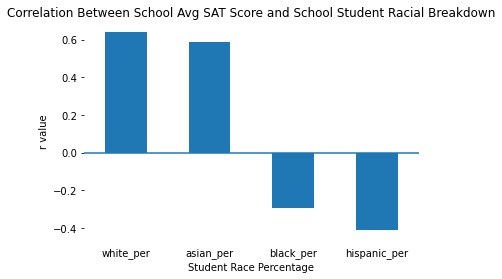

In [14]:
# SAT scores per race
race_cols = ['white_per','asian_per','black_per','hispanic_per']

race_corrs = combined.corr()['sat_score']
race_corrs = race_corrs[race_cols]

fig, ax = plt.subplots()
race_corrs.plot.bar()
plt.title("Correlation Between School Avg SAT Score and School Student Racial Breakdown")
plt.xlabel("Student Race Percentage")
plt.ylabel("r value")
plt.axhline(y=0)
for axis in ["left","right","top","bottom"]:
    ax.spines[axis].set_visible(False)
ax.tick_params(axis="x", labelrotation=0, bottom=False, left=False)
plt.show()

### SAT Scores and School/Class Size

In this dataset, both school size and average class size are positively correlated with the school's SAT score. Upon viewing the total enrollment scatterplot there are a handful of well performing schools with both a high total enrollment and high SAT scores, but there isn't more than a small noticeable positive correlation. On the other hand, the average class size graph does seem to show a clear positive correlation throughout the dataset.

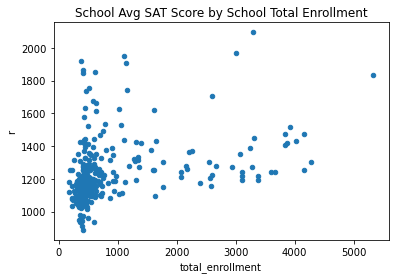

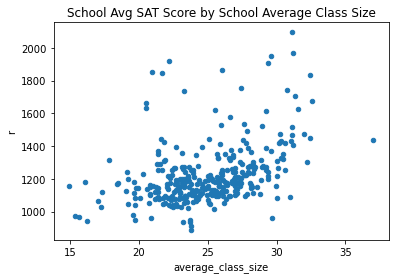

In [15]:
combined.plot.scatter(x='total_enrollment',y='sat_score')
plt.title("School Avg SAT Score by School Total Enrollment")
plt.ylabel("r")
plt.show()

combined.rename(columns={"AVERAGE CLASS SIZE":"average_class_size"}, inplace = True) # align formatting with other graphs
combined.plot.scatter(x='average_class_size',y='sat_score')
plt.title("School Avg SAT Score by School Average Class Size")
plt.ylabel("r")
plt.show()

In [16]:
# Investigate schools with high enrollment and high SAT scores

high_enroll_high_sat = combined[(combined["sat_score"] > 1800) & (combined["total_enrollment"] > 2000)]
display(high_enroll_high_sat[["DBN","SCHOOL NAME","school_dist","total_enrollment","sat_score","white_per","asian_per","black_per","hispanic_per","female_per","male_per"]])                    

,DBN,SCHOOL NAME,school_dist,total_enrollment,sat_score,white_per,asian_per,black_per,hispanic_per,female_per,male_per
31,02M475,STUYVESANT HIGH SCHOOL,02,3297,2096,23.7,72.1,1.2,2.4,40.7,59.3
136,10X445,BRONX HIGH SCHOOL OF SCIENCE,10,3013,1969,25.4,63.5,3.5,7.2,42.2,57.8
170,13K430,BROOKLYN TECHNICAL HIGH SCHOOL,13,5332,1833,21.3,60.3,10.2,7.9,41.7,58.3


We felt it relevant to dig into the large, well-performing schools to better understand what advantages these schools enjoy, or even if there is a data issue. There are three schools with enrollment over 2000 and an average SAT score over 1800 we investigated:

1. [Stuyvesant High School](https://en.wikipedia.org/wiki/Stuyvesant_High_School) - an extremely competitive school in Manhattan, one of the nine [specialized high schools in NYC](https://en.wikipedia.org/wiki/Specialized_high_schools_in_New_York_City), that consistently ranks as one of the best public high schools in the country. Enrollment is based on performance on the Specialized High Schools Admissions Test, or SHSAT, a standardized test.

2. [Bronx High School of Science](https://en.wikipedia.org/wiki/Bronx_High_School_of_Science) - another specialized high school. This school has produced the most Nobel laureates of any secondary school in the world.

3. [Brooklyn Technical High School](https://en.wikipedia.org/wiki/Brooklyn_Technical_High_School) - also a specialized school in the NYC public school system.  Brooklyn Tech is the largest of the specialized high schools, but it still seen as incredibly selective and prestigious and admission is based on the SHSAT.

While the SAT scores for these high schools are correct, these three schools are the original three NYC specialized high schools and the three most prestigious magnet schools in the city. Thus it's difficult to see how the high achieving nature of these institutions can be applied to the NYC school system more widely.

Digging into the demographics of these schools further, they are all majority Asian and male. If anything, it's surprising that considering these highest achieving high schools, White student percent and female student percent have the highest SAT score correlations over the other race and male percentages respectively.

### Gender

Another demographic to study is gender. There is a slight positive correlation between female student percentage and average SAT score. From viewing the scatterplot below, there are a number of schools between 60 and 80 percent female with high (over 1700) SAT scores that may warrant further investigation on what they are doing well.

School Gender Proportion Correlation with SAT Score
male_per     -0.119615
female_per    0.119664
Name: sat_score, dtype: float64


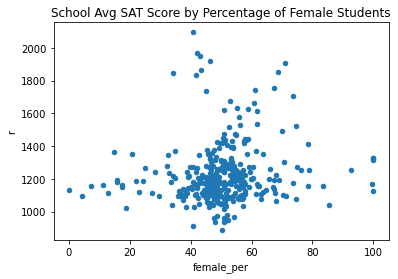

,DBN,SCHOOL NAME,school_dist,sat_score,total_enrollment,white_per,asian_per,black_per,hispanic_per,female_per,male_per
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,01,1856,617,49.8,15.1,15.1,18.2,68.7,31.3
23,02M416,ELEANOR ROOSEVELT HIGH SCHOOL,02,1758,507,63.7,17.2,5.5,11.6,67.5,32.5
51,03M479,BEACON HIGH SCHOOL,03,1744,1162,49.8,8.9,14.6,22.8,61.0,39.0
52,03M485,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,03,1707,2605,49.2,19.6,12.9,16.6,73.6,26.4
279,25Q525,TOWNSEND HARRIS HIGH SCHOOL,25,1910,1140,24.6,55.5,5.9,12.9,71.1,28.9


In [17]:
gender_corr = combined.corr().loc[["male_per","female_per"],"sat_score"]
print("School Gender Proportion Correlation with SAT Score")
print(gender_corr)

combined.plot.scatter(x="female_per",y="sat_score")
plt.title("School Avg SAT Score by Percentage of Female Students")
plt.ylabel("r")
plt.show()

# Isolate schools with over 60 percent female student population and SAT scores over 1700
high_female_high_sat = combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]
display(high_female_high_sat[["DBN","SCHOOL NAME","school_dist","sat_score","total_enrollment","white_per","asian_per","black_per","hispanic_per","female_per","male_per"]])

Researching these high schools, they are all a magnet school or have some kind of competitive application process. Eleanor Roosevelt and Townsend Harris High Schools have a reputation for a more liberal arts-based curriculum than most schools, while LaGuardia High is focused on music and art. The Beacon School and Bard High School Early College school use alternative structures than standard schools, with Beacon having portfolio-based assessments instead of testing and Bard giving out both high school and associate's degrees at the same time to one student. These schools make up a different sector of high-achieving institutions in the New York City school system, but they also represent the most prestigious and competitive schools of the system alongside the high enrollment/high SAT schools.

### AP Test Results

Since AP tests are one of the USA's other major standardized testing programs, we looked at whether a school's students taking or passing a higher proportion of AP tests would correlate with success on the SAT. 

AP Column Correlations with SAT Score


sat_score                   1.000000
ap_per                      0.729992
ap_exams_per_test_taker     0.314435
ap_passes_per_test_taker    0.631840
Name: sat_score, dtype: float64

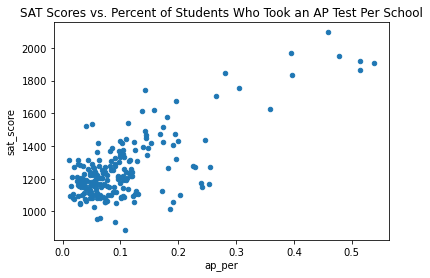

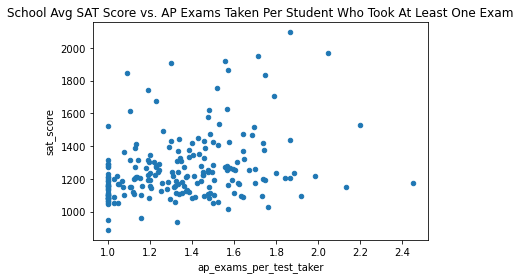

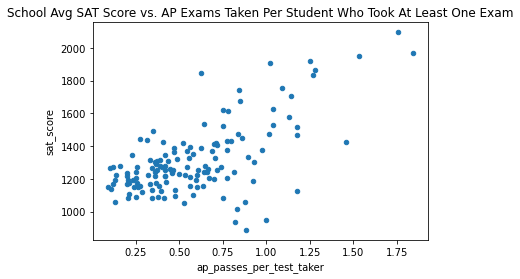

In [18]:
# Create columns for standardized AP Test Info
combined.rename(columns={"AP Test Takers ":"AP Test Takers"}, inplace=True)
combined["ap_per"] = combined["AP Test Takers"] / combined['total_enrollment']
combined["ap_exams_per_test_taker"] = combined["Total Exams Taken"] / combined["AP Test Takers"]
combined["ap_passes_per_test_taker"] = combined["Number of Exams with scores 3 4 or 5"] / combined["AP Test Takers"]

ap_correlations = combined[["sat_score","ap_per","ap_exams_per_test_taker","ap_passes_per_test_taker"]].corr()

print("AP Column Correlations with SAT Score")
display(ap_correlations["sat_score"])

combined.plot.scatter(x='ap_per',y='sat_score')
plt.title('SAT Scores vs. Percent of Students Who Took an AP Test Per School')
plt.show()

combined.plot.scatter(x='ap_exams_per_test_taker',y='sat_score')
plt.title('School Avg SAT Score vs. AP Exams Taken Per Student Who Took At Least One Exam')
plt.show()

combined.plot.scatter(x='ap_passes_per_test_taker',y='sat_score')
plt.title('School Avg SAT Score vs. AP Exams Taken Per Student Who Took At Least One Exam')
plt.show()

While all three values regarding AP tests are positively correlated with a school's average SAT score, the percent of students at a school taking AP exams and the amount of exams each student is passing are more highly correlated than whether students are taking multiple exams. Overall this data shows the success of AP curricula in leading to improved SAT scores, although there are a number of other correlated variables to consider as well. While it makes sense that students passing AP tests would be more tightly correlated with SAT scores than simply taking AP tests, we are surprised that taking more exams doesn't correlate more with SAT scores. Perhaps some schools are requiring AP tests for students in an effort to establish high academic standards, but some students are struggling to meet them in terms of standardized test performance.

## Survey Data

The last dataset we will analyze is the NYC School Survey data we collected. Similar to the other data, we'll start by examining the overall correlation value between a school's average sat score and each data point to determine areas to prioritize further investigation.  Note that we removed outliers where the average school safety score was originally missing, but we set the value to zero when joining survey data to our overall dataset.

Looking at the [2011 NYC School Survey data dictionary](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8), the column naming convention is as follows.

rr - Response rate  
N - Number of survey takers  
saf - Safety score  
com - Communication score  
eng - Engagement score  
aca - Academic Expectations score  

_s - Student responses  
_t - Teacher responses  
_p - Parent responses  
_tot - All responses together (total)

11 - Grade 11

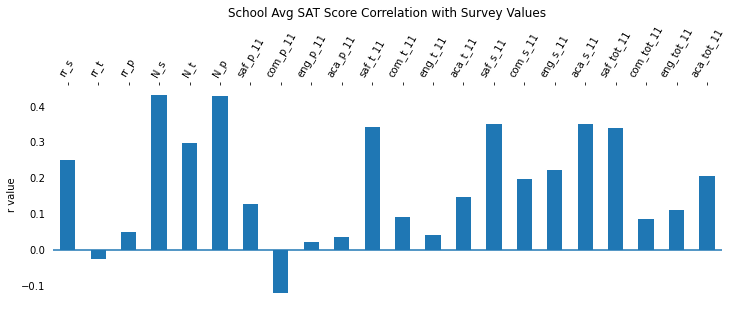

In [19]:
#Plot correlations
survey_fields = [ 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]

# # Reset originally missing values back to NaN
# survey_results = combined[survey_fields]
# survey_results = survey_results.replace(0, numpy.nan)
# combined[survey_fields] = survey_results

survey_corrs = combined.corr()["sat_score"]
survey_corrs = survey_corrs[survey_fields]

fig, ax = plt.subplots(figsize=(12,4))
survey_corrs.plot.bar(y=survey_corrs)
plt.title("School Avg SAT Score Correlation with Survey Values")
plt.ylabel("r value")
ax.tick_params(axis="x", labelrotation=60)
ax.tick_params(left=False)
ax.xaxis.tick_top()
for axis in ["left","right","top","bottom"]:
    ax.spines[axis].set_visible(False)
plt.axhline(y=0)
plt.show()

Reviewing the correlations, the most positively correlated values are the number of students and parents who took the survey from a given school. Perhaps the largest takeaway is that simply being engaged with the school enough to respond to a school survey shows a higher achieving school community. It also aligns with our earlier finding that higher total enrollment is positively correlated with SAT score.

Comparing the correlation values between student, teacher, and parent responses, the student survey responses have a higher correlation with SAT score. This suggests that students have a better pulse on how their school experience is impacting potential outcomes than teachers or parents do.

Within the individual survey scores, the safety score has the highest correlation value for each category of respondents, although the parent value is lower than students and teachers. Thus we'll focus on safety scores for deeper investigation.

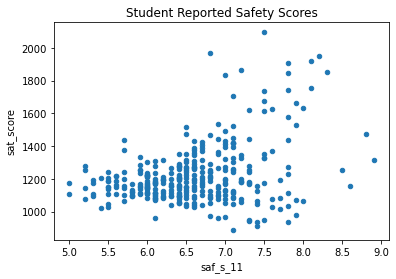

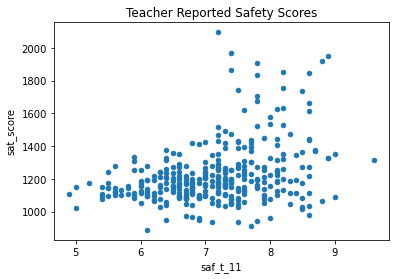

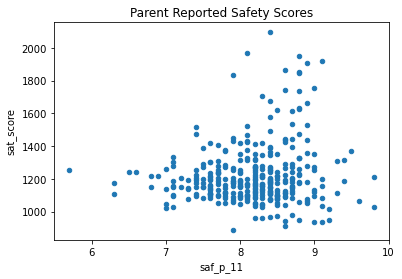

In [20]:
# Safety score scatter plots
combined.plot.scatter(x="saf_s_11",y="sat_score")
plt.title("Student Reported Safety Scores")
plt.show()

combined.plot.scatter(x='saf_t_11',y='sat_score')
plt.title('Teacher Reported Safety Scores')
plt.show()

combined.plot.scatter(x='saf_p_11',y='sat_score')
plt.title('Parent Reported Safety Scores')
plt.show()

The SAT score vs. safety score graph for all three groups has the same general shape, where only higher rated schools in regards to safety tend to be the ones with high average SAT scores. That being said, there are a number of schools with high safety ratings but still average or below SAT scores, so while safety seems to be a prerequisite for higher SAT scores, it does not appear to be the only factor at play.

There is a noticeable trend where students give the lowest safety scores, followed by teachers and then parents. In fact, when examining the parent plot the general shape is the same as the others but there are so many high scores that there are many schools in the category of high safety scores but average or below SAT scores. This would explain the less positive correlation for parent responses than students or teachers.

Another area we can explore in regards to safety and SAT scores is breaking down the data by borough; New York City famously has five boroughs, each representing a different county and maintaining their own local government, although the public school system is managed city wide. We'll examine the mean SAT score and safety score of each borough.

In [21]:
#Safety Scores by Borough
safety_by_borough_count = combined.groupby("boro").size()
safety_by_borough_count.rename("school_count", inplace=True) # Note that count isn't necessarily the same
safety_by_borough_data = combined.groupby("boro").agg(numpy.mean).loc[:,["sat_score","saf_s_11","saf_t_11","saf_p_11"]]
safety_by_borough = pd.concat([safety_by_borough_count,safety_by_borough_data],axis=1)
display(safety_by_borough)

,school_count,sat_score,saf_s_11,saf_t_11,saf_p_11
boro,,,,,
Bronx,87,1153.057471,6.604598,7.018391,8.337931
Brooklyn,100,1178.840000,6.372000,7.016000,8.051000
Manhattan,79,1285.974684,6.812987,7.293671,8.264557
Queens,59,1292.118644,6.708475,7.349153,8.067797
Staten Island,10,1382.500000,6.530000,7.210000,7.800000


Starting with SAT score, Staten Island has the highest average SAT for its schools, although the sample size is small. In terms of safety scores, Manhattan and Queens have the highest scores for students and teachers, although curiously for parents the Bronx has the highest safety scores. Brooklyn has the lowest score for students and teachers, while for parents Staten Island has the lowest value.

## Conclusion

In this analysis, we gathered SAT score data on high schools published by the New York City Government and combined it with other school data to investigate which factors were more correlated with SAT performance than others. The topics we investigated included race, school and class size, gender, AP Test information, and safety ratings from the NYC School Survey.

### Initial Interpretations

In analyzing this data, the first high level information we learned was there are large disparities between high schools in the New York City system, much of which is designed. The highest scoring large schools are specialized schools that only admit students through a rigorous examination process, not simply by enrolling the students in the neighborhood. Even outside of the specialized school framework, many of the other high performing schools admit only a sliver of the students interested in their programs. Much of this is by design to ensure the most promising students are sufficiently challenged, but at the same time the system must not try and leave other students behind.

The highest correlations, both positive and negative, with SAT scores that we studied were associated with the racial makeup of the students of a given high school. Disparities in outcomes for minority students are well chronicled and these data confirm that New York City was seeing these outcomes in the time period of these datasets.

Perhaps the most surprising finding was that both school total enrollment and average class size were positively correlated with a school's average SAT score. For the total enrollment correlation we learned that the highest performing large schools were the highly competitive original NYC specialized schools, so it's expected that they pull the correlation upward. One hypothesis is that the highest performing schools are growing over time to meet demand so in the aggregate larger schools are performing better academically.

### Future Analysis

There are many potential paths for further analysis on such a rich subject matter, but we recommend a few potential projects. 

First, this analysis and its next steps assume that the SAT is a reasonable measure for academic success and improving SAT scores is a worthy endeavor for high schools in New York City. Over the past few years the efficacy and equality of the SAT has been called into question, so before moving forward with further analysis we should perform another round of research on whether the SAT is the proper measure to use to quantify success and whether another measure such as graduation rates, GPA, etc. would be a better focus for this work.

We also see value in investigating the correlation between class size and average school SAT score further as we interpret this trend as potentially actionable for all schools across New York City, not only the specialized and magnet schools that are performing well. While it's hard to believe that a larger class size would have a causative relationship with SAT scores, we can investigate the schools that are performing well or poorly that have different class size to better understand what they may be doing differently. One potential hypothesis is that high scoring schools have increased in size over time to accommodate demand, leaving them larger on average than lower scoring schools.

Last, while a numeric student safety score provides initial context for analysis and we established a positive correlation between safety and SAT scores, it is difficult to move forward with clear steps and recommendations without a more granular understanding of what safety means as it's likely different for different people. We could investigate if any other data came from the NYC school survey that helps outline what about certain schools makes students feel safe or unsafe and correlate that more detailed data with SAT outcomes.